###### Signal Generator for making a market view for Index Options of Indian Stock Market Benchmark Index NIFTY 50 

##### Fundamentals of Artificial Intelligence 
CSCE 5210 – SPRING 2022 – Academic Project

Submitted by :

Veeranjaneyulu Muppala 11532514

Yash Zauwar	11439929


In [1]:
# Libraries
import requests
import json
import math

# defining to print colored text and background
def strRed(skk):         return "\033[91m {}\033[00m".format(skk)
def strGreen(skk):       return "\033[92m {}\033[00m".format(skk)
def strYellow(skk):      return "\033[93m {}\033[00m".format(skk)
def strLightPurple(skk): return "\033[94m {}\033[00m".format(skk)
def strPurple(skk):      return "\033[95m {}\033[00m".format(skk)
def strCyan(skk):        return "\033[96m {}\033[00m".format(skk)
def strLightGray(skk):   return "\033[97m {}\033[00m".format(skk)
def strBlack(skk):       return "\033[98m {}\033[00m".format(skk)
def strBold(skk):        return "\033[1m {}\033[0m".format(skk)

# Method to get nearest strike price
def round_nearest(x,num=50): return int(math.ceil(float(x)/num)*num)
def nearest_strike_bnf(x): return round_nearest(x,100)
def nearest_strike_nf(x): return round_nearest(x,50)

# Urls for fetching Data - obtained from National Stock Exchange
url_oc      = "https://www.nseindia.com/option-chain"
url_bnf     = 'https://www.nseindia.com/api/option-chain-indices?symbol=BANKNIFTY'
url_nf      = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'
url_indices = "https://www.nseindia.com/api/allIndices"

# Headers taken from chrome browser while accesing the website
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36',
            'accept-language': 'en,gu;q=0.9,hi;q=0.8',
            'accept-encoding': 'gzip, deflate, br'}

#crearting an session
sess = requests.Session()
cookies = dict()

# Local methods
def set_cookie():
    request = sess.get(url_oc, headers=headers, timeout=5)
    cookies = dict(request.cookies)

def get_data(url):
    set_cookie()
    response = sess.get(url, headers=headers, timeout=5, cookies=cookies)
    if(response.status_code==401):
        set_cookie()
        response = sess.get(url_nf, headers=headers, timeout=5, cookies=cookies)
    if(response.status_code==200):
        return response.text
    return ""

def set_header():
    global nf_ul
    global nf_nearest
    response_text = get_data(url_indices)
    data = json.loads(response_text)
    for index in data["data"]:
        if index["index"]=="NIFTY 50":
            nf_ul = index["last"]
            print("nifty")
    nf_nearest=nearest_strike_nf(nf_ul)

# Showing Header in structured format with Last Price and Nearest Strike

def print_header(index="",ul=0,nearest=0):
    print(strPurple( index.ljust(12," ") + " => ")+ strLightPurple(" Last Price: ") + strBold(str(ul)) + strLightPurple(" Nearest Strike: ") + strBold(str(nearest)))

def print_hr():
    print(strYellow("|".rjust(70,"-")))

# Fetching CE and PE data based on Nearest Expiry Date
def print_oi(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    CE_d = []
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                #print(strCyan(str(item["strikePrice"])) + strGreen(" CE ") + "[ " + strBold(str(item["CE"]["openInterest"]).rjust(10," ")) + " ]" + strRed(" PE ")+"[ " + strBold(str(item["PE"]["openInterest"]).rjust(10," ")) + " ]")
                print(data["records"]["expiryDates"][0] + " " + str(item["strikePrice"]) + " CE " + "[ " + strBold(str(item["CE"]["openInterest"]).rjust(10," ")) + " ]" + " PE " + "[ " + strBold(str(item["PE"]["openInterest"]).rjust(10," ")) + " ]")
                CE_d.append(item["strikePrice"])
                #print(item["strikePrice"])
                strike = strike + step
                #print(CE_d[str(item["strikePrice"])])
        
# Finding highest Open Interest of People's in CE based on CE data         
def highest_oi_CE(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    max_oi = 0
    max_oi_strike = 0
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                if item["CE"]["openInterest"] > max_oi:
                    max_oi = item["CE"]["openInterest"]
                    max_oi_strike = item["strikePrice"]
                strike = strike + step
    return max_oi_strike

# Finding highest Open Interest of People's in PE based on PE data 
def highest_oi_PE(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    max_oi = 0
    max_oi_strike = 0
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                if item["PE"]["openInterest"] > max_oi:
                    max_oi = item["PE"]["openInterest"]
                    max_oi_strike = item["strikePrice"]
                strike = strike + step
    return max_oi_strike

def diff_in_CE_PE(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    max_oi = 0
    max_oi_strike = 0
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                if item["PE"]["openInterest"] > max_oi:
                    diff_in_ce_pe = item["PE"]["openInterest"] - item["CE"]["openInterest"]
                    print(str(diff_in_ce_pe))
                strike = strike + step
    return diff_in_ce_pe


set_header()
print_hr()
print_header("Nifty",nf_ul,nf_nearest)
print_hr()
print_oi(10,50,nf_nearest,url_nf)
print_hr()


# Finding Highest OI in Call Option In Nifty
nf_highestoi_CE = highest_oi_CE(10,50,nf_nearest,url_nf)

# Finding Highet OI in Put Option In Nifty
nf_highestoi_PE = highest_oi_PE(10,50,nf_nearest,url_nf)


print(strCyan(str("Major Resistance in Nifty:")) + str(nf_highestoi_CE))
print(strCyan(str("Major Support in Nifty:")) + str(nf_highestoi_PE))



nifty
 ---------------------------------------------------------------------|
 Nifty        =>   Last Price:  17069.1  Nearest Strike:  17100
 ---------------------------------------------------------------------|
05-May-2022 16600 CE [         783 ] PE [       38934 ]
05-May-2022 16650 CE [         231 ] PE [       10914 ]
05-May-2022 16700 CE [        1376 ] PE [       48548 ]
05-May-2022 16750 CE [         205 ] PE [       17028 ]
05-May-2022 16800 CE [        4609 ] PE [       72253 ]
05-May-2022 16850 CE [        1053 ] PE [       19817 ]
05-May-2022 16900 CE [       14816 ] PE [       69262 ]
05-May-2022 16950 CE [        6408 ] PE [       20440 ]
05-May-2022 17000 CE [       66872 ] PE [      115802 ]
05-May-2022 17050 CE [       18853 ] PE [       33079 ]
05-May-2022 17100 CE [       64381 ] PE [       45417 ]
05-May-2022 17150 CE [       18071 ] PE [        5211 ]
05-May-2022 17200 CE [       62908 ] PE [       22186 ]
05-May-2022 17250 CE [       31243 ] PE [        5293 ]
05

In [2]:
def print_ce_data(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    n_ce_data = []
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                strike = strike + step
                n_ce_data.append(((item["CE"]["openInterest"])))
   # print(n_ce_data)
    #print(n_pe_data)       
    return n_ce_data

def print_pe_data(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    n_pe_data = []
    n_strike_data = []
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                strike = strike + step
                n_pe_data.append(((item["PE"]["openInterest"])))
   # print(n_ce_data)
    #print(n_pe_data)       
    return n_pe_data

def print_ce_coi_data(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    n_ce_coi_data = []
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                strike = strike + step
                n_ce_coi_data.append(((item["CE"]["changeinOpenInterest"])))
   # print(n_ce_data)
    #print(n_pe_data)       
    return n_ce_coi_data

def print_pe_coi_data(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    n_pe_coi_data = []
    #n_strike_data = []
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                strike = strike + step
                n_pe_coi_data.append(((item["PE"]["changeinOpenInterest"])))
   # print(n_ce_data)
    #print(n_pe_data)       
    return n_pe_coi_data

def print_strike_data(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    n_strike_data = []
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                strike = strike + step
                n_strike_data.append(((item["strikePrice"])))
   # print(n_ce_data)
    #print(n_pe_data)       
    return n_strike_data

### Finding the Major Resistance and Major Support as per the current data

In [4]:
print(strCyan(str("Major Resistance in Nifty:")) + str(nf_highestoi_CE))
print(strCyan(str("Major Support in Nifty:")) + str(nf_highestoi_PE))

 Major Resistance in Nifty:17500
 Major Support in Nifty:17000


### Finding the Total OI on call, put and change in Open Interest in call and put as per current data 

In [5]:
a = print_ce_data(10,50,nf_nearest,url_nf)
#print(a)
b = print_pe_data(10,50,nf_nearest,url_nf)
#print(b)
c=print_strike_data(10,50,nf_nearest,url_nf)
#print(c)
d = print_ce_coi_data(10,50,nf_nearest,url_nf)
#print(d)
e = print_pe_coi_data(10,50,nf_nearest,url_nf)
#print(e)
sum_ce_time = []
sum_pe_time = []
sum_oi_ce = 0;
sum_oi_pe = 0;
sum_ce = 0;
sum_pe = 0; 
for i in range(0, len(a)):
    sum_oi_ce = sum_oi_ce + a[i];  
print(" Total OI on CALL SIDE " + str(sum_oi_ce));
for i in range(0, len(b)):
    sum_oi_pe = sum_oi_pe + b[i];  
print(" Total OI on PUT SIDE " + str(sum_oi_pe));
for i in range(0, len(d)):
    sum_ce = sum_ce + d[i];  
print(" Total Change of OI on CALL SIDE " + str(sum_ce));
for i in range(0, len(e)):    
    sum_pe = sum_pe + e[i];     
print(" Total Change of OI on PUT SIDE " + str(sum_pe));
if  sum_ce < sum_pe:
    print(strGreen(str("SIGNAL GIVEN BY DATA IS BUY")))
    signal_by_oi = 'B' 
else:
    print(strRed(str("SIGNAL GIVEN BY DATA IS SELL")))
    signal_by_oi = 'S' 

 Total OI on CALL SIDE 730281
 Total OI on PUT SIDE 554089
 Total Change of OI on CALL SIDE 202235
 Total Change of OI on PUT SIDE 32776
 SIGNAL GIVEN BY DATA IS SELL


# Plotting a Visual Bar Graph where Red bars indicate the Resistance and Green bars indicate the support

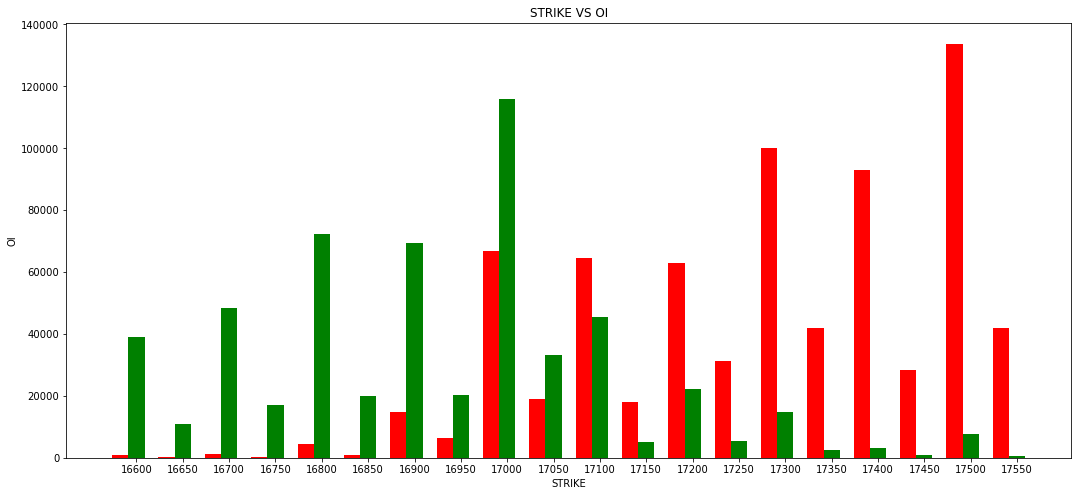

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#storing the values in variables a,b,c
a = print_ce_data(10,50,nf_nearest,url_nf)
#print(a)
b = print_pe_data(10,50,nf_nearest,url_nf)
#print(b)
c=print_strike_data(10,50,nf_nearest,url_nf)
#print(c)
# data to plot
n_groups = 20
# create plot
index = np.arange(20)
#printing graph for 20 strike prices
plt.figure(figsize=(18,8))
bar_width = 0.35
rects1 = plt.bar(index, a, bar_width,color='r',label='CE')
rects2 = plt.bar(index + bar_width, b, bar_width,color='g',label='PE')
plt.xlabel('STRIKE')
plt.ylabel('OI')
plt.title('STRIKE VS OI')
plt.xticks(index + bar_width, c)
plt.show()

# calculating Put Call Ratio

In [7]:
pcr =  sum_oi_pe/sum_oi_ce
print(pcr)
if pcr < 1:
    print("SIGNAL GIVEN BY PCR IS SELL")
    signal_by_pcr = 'S'
else:
    print("SIGNAL GIVEN BY PCR IS BUY")
    signal_by_pcr = 'B'

0.7587339667881268
SIGNAL GIVEN BY PCR IS SELL


# Combining the Signal generated from Put Call Ratio and the Open Interest data to make a directional market view

In [8]:
if (signal_by_oi == 'S' and signal_by_pcr == 'S'):
    print("THE FINAL SIGNAL AFTER COMBINING PCR AND OI Data is -- SELL")
elif(signal_by_oi == 'B' and signal_by_pcr == 'B'):
    print("THE FINAL SIGNAL AFTER COMBINING PCR AND OI Data is -- BUY")
else:
    print("DERIVATIVE DATA HAS NO DIRECTIONAL VIEW : Please try after sometime")

THE FINAL SIGNAL AFTER COMBINING PCR AND OI Data is -- SELL
